In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler



# Load your DataFrame here
# final_df = pd.read_csv('10min_data_sentiment_type1.csv')  # Assuming data is loaded into final_df
final_df = pd.read_csv('10mins_data.csv') 

# Convert index to datetime if necessary
final_df['date'] = pd.to_datetime(final_df['date'])
final_df.set_index('date', inplace=True)


# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = final_df['close'].values.reshape(-1,1)
scaled_close_prices = scaler.fit_transform(close_prices)

# Prepare dataset using only close prices
def create_dataset(data, time_step=10):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]  # Only close prices
        x.append(a)
        y.append(data[i + time_step, 0])  # Next close value
    return np.array(x), np.array(y)

time_step = 10
X, y = create_dataset(scaled_close_prices, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]


C:\Users\chand\AppData\Local\Temp\ipykernel_31472\1688703694.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  final_df['date'] = pd.to_datetime(final_df['date'])


In [81]:
X.shape

(12002, 10, 1)

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Define LSTM layer
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        
        # Define output layer
        self.linear1 = nn.Linear(hidden_dim, 25)
        self.linear2 = nn.Linear(25, output_dim)

    def forward(self, x):
        # Forward pass through LSTM layer
        # shape of x: (batch_size, seq_length, input_dim)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Only take the output from the final timestep
        x = x[:, -1, :]
        
        # Pass the output of LSTM to a Fully Connected layer
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# Hyperparameters
input_dim = 1   # Input dimension of each time step
hidden_dim = 50 # Hidden layer dimension
output_dim = 1  # Output dimension
time_step = 10  # Number of time steps (length of the sequence)

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_dim, hidden_dim, output_dim).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X = torch.from_numpy(X).float()  # Convert and change datatype to float
y = torch.from_numpy(y).float()

# If using a GPU, move tensors to GPU
X = X.to(device)
y = y.to(device)

# Training the model
num_epochs = 10
batch_size = 64

for epoch in range(num_epochs):
    for i in range(0, len(X), batch_size):
        # Get the mini-batch
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



c:\Users\chand\miniconda3\envs\resurgence\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\chand\miniconda3\envs\resurgence\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.0039
Epoch [2/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0131
Epoch [4/10], Loss: 0.0170
Epoch [5/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0137
Epoch [7/10], Loss: 0.0102
Epoch [8/10], Loss: 0.0148
Epoch [9/10], Loss: 0.0168
Epoch [10/10], Loss: 0.0182


In [83]:
# Generate predictions
model.eval()

# Generate predictions
with torch.no_grad():
    X = X.to(device)  # Ensure X is on the correct device
    predicted_tensor = model(X)

# Convert predictions back to numpy array
predicted_numpy = predicted_tensor.cpu().numpy()

# Rescale the predictions to original scale
predicted_prices = scaler.inverse_transform(predicted_numpy) #Correct shape for inverse transformation

# Incorporate predictions into DataFrame
trades = pd.DataFrame(index=final_df.index[time_step+1:])
trades['Predicted'] = predicted_prices.ravel()  # Flatten array
trades['Actual'] = final_df['close'][time_step+1:]

trades['Signal'] = 0
trades['Signal'] = np.where(trades['Predicted'] > trades['Actual'].shift(), 1, -1)


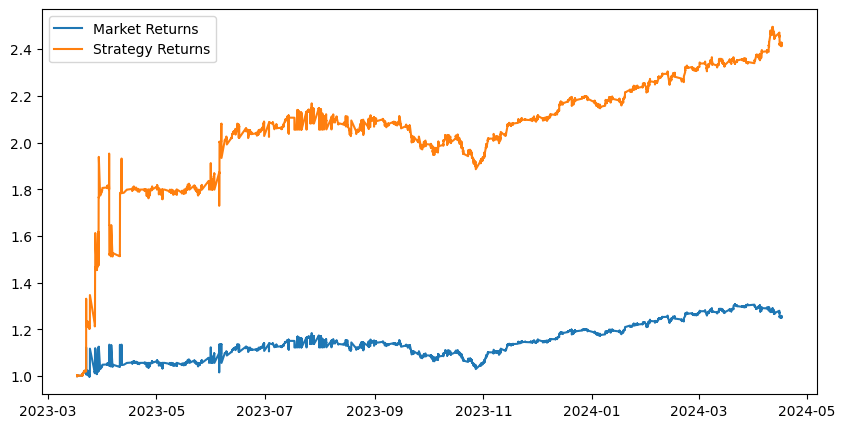

In [84]:
# Calculate returns
trades['Returns'] = trades['Actual'].pct_change()
trades['Strategy'] = trades['Signal'].shift() * trades['Returns']

# Calculate cumulative returns
trades['Cumulative Strategy Returns'] = (1 + trades['Strategy']).cumprod()
trades['Cumulative Market Returns'] = (1 + trades['Returns']).cumprod()

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(trades['Cumulative Market Returns'], label='Market Returns')
plt.plot(trades['Cumulative Strategy Returns'], label='Strategy Returns')
plt.legend()
plt.show()


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume 'predicted_prices' and 'trades' are already defined from previous steps

# Calculate error metrics
mse = mean_squared_error(trades['Actual'], trades['Predicted'])
mae = mean_absolute_error(trades['Actual'], trades['Predicted'])
rmse = np.sqrt(mse)  # Root Mean Squared Error

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)


Mean Squared Error: 69096.01269803324
Mean Absolute Error: 218.0165078281224
Root Mean Squared Error: 262.86120424671503


In [86]:
import numpy as np

# Calculate MAPE and MdAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate error metrics including MAPE and MdAPE
mape = mean_absolute_percentage_error(trades['Actual'], trades['Predicted'])
mdape = median_absolute_percentage_error(trades['Actual'], trades['Predicted'])

print("Mean Absolute Percentage Error (MAPE):", mape)
print("Median Absolute Percentage Error (MdAPE):", mdape)

Mean Absolute Percentage Error (MAPE): 4.6781409210515426
Median Absolute Percentage Error (MdAPE): 3.959181578260959
